In [ ]:
 ! pip install -q kaggle
 
from google.colab import files
 
files.upload()
 
! mkdir ~/.kaggle
 
! cp kaggle.json ~/.kaggle/
 
! chmod 600 ~/.kaggle/kaggle.json
 
! kaggle datasets list

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!kaggle datasets download -d emmarex/plantdisease

100% 657M/658M [00:18<00:00, 27.8MB/s]
100% 658M/658M [00:18<00:00, 36.6MB/s]


In [ ]:
!unzip /content/plantdisease.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-7476153023ce___YLCV_GCREC 2258.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/092330d8-f6e9-48df-8525-cb

In [ ]:

import numpy as np
import pickle
import cv2
from os import listdir
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



In [ ]:


Epochs= 14
lr= 1e-3
Batchsize = 32
default_image_size = tuple((128, 128))
image_size = 0
directory_root = '/content/plantvillage'
width=128
height=128
depth=3



In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:


image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    print(root_dir)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:400]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")
image_size = len(image_list)
print (f"total image processed {image_size} ")



[INFO] Loading images ...
['PlantVillage']
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Image loading completed
total image processed 5725 


In [ ]:
image_labels = []
count=0
for label in label_list:
    if label.split('_')[len(label.split('_'))-1] == 'healthy':
        count+=1
        image_labels.append(0)
    else:
        image_labels.append(1)

In [ ]:

import numpy as np
image_list = np.array(image_list, dtype=np.float16) 
image_label=np.array(image_labels)
image_list=image_list.reshape(5725,128*128*3)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(image_list, image_label)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
np_image_list=x_res.reshape(9546,128,128,3)
image_label=y_res

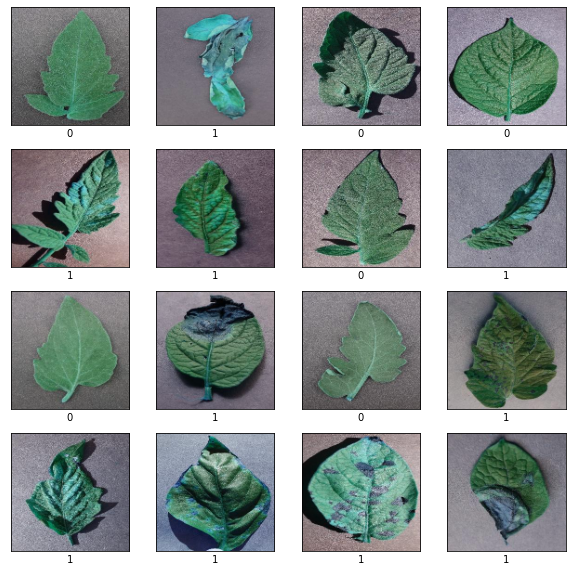

In [ ]:
%matplotlib inline
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(10,10))
for i in range (16):
  n = random.randint(1,5000)
  plt.subplot(4,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow((np_image_list[n]).astype(np.uint8))
  plt.xlabel(image_label[n])
plt.show()

In [ ]:
np_image_list/=255

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_label, test_size=0.2,shuffle=True) 

In [ ]:

imageaug = ImageDataGenerator(
    
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True,vertical_flip=True,
    fill_mode="nearest")

In [ ]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Flatten,Dense,Dropout
model = tf.keras.models.Sequential()
from tensorflow.keras.layers import Activation
inputShape = (height, width, depth)


model.add(Conv2D(32, (3, 3), padding="same",activation='relu',input_shape=inputShape))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding="same",activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding="same",activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same",activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), padding="same",activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same",activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512,activation='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))



In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 42, 42, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 42, 42, 64)       

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=lr, decay=lr/Epochs),metrics=["accuracy"])

In [ ]:
history = model.fit(
    imageaug.flow(x_train, y_train, batch_size=Batchsize),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) / Batchsize,
    validation_steps=len(x_test)/Batchsize,
    epochs=Epochs, verbose=1
    )

Epoch 1/14
239/238 [==============================] - 42s 178ms/step - loss: 0.2467 - accuracy: 0.9036 - val_loss: 8.2362 - val_accuracy: 0.5209
Epoch 2/14
239/238 [==============================] - 40s 168ms/step - loss: 0.1457 - accuracy: 0.9446 - val_loss: 0.3621 - val_accuracy: 0.8942
Epoch 3/14
239/238 [==============================] - 40s 166ms/step - loss: 0.0943 - accuracy: 0.9652 - val_loss: 0.0780 - val_accuracy: 0.9675
Epoch 4/14
239/238 [==============================] - 40s 165ms/step - loss: 0.0646 - accuracy: 0.9751 - val_loss: 0.5086 - val_accuracy: 0.8681
Epoch 5/14
239/238 [==============================] - 42s 174ms/step - loss: 0.0609 - accuracy: 0.9785 - val_loss: 0.0620 - val_accuracy: 0.9806
Epoch 6/14
239/238 [==============================] - 41s 171ms/step - loss: 0.0539 - accuracy: 0.9793 - val_loss: 0.0972 - val_accuracy: 0.9602
Epoch 7/14
239/238 [==============================] - 40s 168ms/step - loss: 0.0459 - accuracy: 0.9848 - val_loss: 0.1037 - val_ac

In [ ]:
model.save('plantdisease.keras')

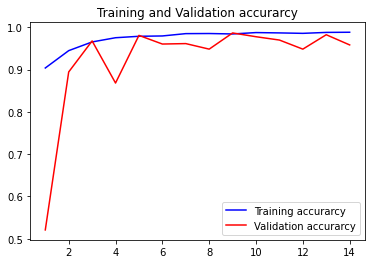

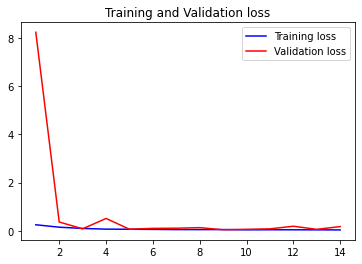

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(x_test,y_test)

60/60 [==============================] - 1s 24ms/step - loss: 0.1712 - accuracy: 0.9581


[0.17121471464633942, 0.9581151604652405]

In [ ]:

import numpy as np
from sklearn.metrics import confusion_matrix 
y_true=[]
for element in y_test:
    y_true.append(element)
prediction_proba= model.predict(x_test)
prediction=[]
for pred in prediction_proba:
  if pred >0.5:
    prediction.append(1)
  else:
    prediction.append(0)
cnf_matrix = confusion_matrix(y_true,prediction)

In [ ]:
cnf_matrix

array([[989,   0],
       [ 80, 841]])

In [ ]:

import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Normalized confusion matrix


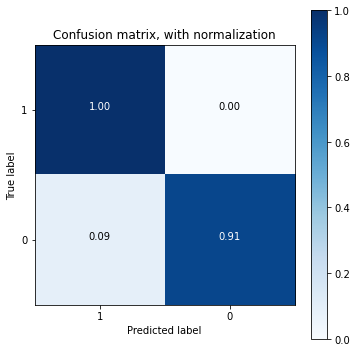

In [ ]:
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['1' , '0'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

In [ ]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)


#img_path = random.choice(cat_img_files + dog_img_files)
#img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = image_list[600, :]                          # Numpy array with shape (150, 150, 3)
x   = x.reshape(1, 128, 128, 3)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 